In [48]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
import keras.models as km
import keras.layers as kl
import keras.activations as ka
import keras.layers.advanced_activations as kla

In [51]:
from keras import backend

In [52]:
from tensorflow.python.client import device_lib

In [53]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8931808852505277522, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18251848448588341857
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6924743809988139107
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 95556148136808875
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 in

In [54]:
def clayer(nfeatures, kernel_size=(3, 3), strides=(1,1), use_bias=True, **kwargs):
    
    return kl.Conv2D(nfeatures,
                     kernel_size=kernel_size,strides=strides, 
                     use_bias=use_bias, padding='same', **kwargs)

def NonLinearity():
    
    #return kl.Activation('relu')
    return kla.LeakyReLU(alpha=0.1)

def ResBlock(x, nf, dropout=None, **kwargs):
    
    shortcut = x
    x = clayer(nf, **kwargs)(x)
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    
    return x

def DownBlock(x, nf, dropout=None, **kwargs):
    """
    This reduces the dimensionality using convolutions.
    """
    
    shortcut = clayer(nf, kernel_size=(1,1), strides=(2,2), **kwargs)(x)
    x = clayer(nf, kernel_size=(2,2), strides=(2,2), **kwargs)(x)
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
        
    return x


def get_discriminator(input_shape, nclasses=1, nlevels=4, base_features=32, dropout=None, **kwargs):
    """
    Returns a 2D CNN based on the ResNet model.
    Parameters
    ---------
    input_shape : np.array((3))
        Specifies the size of the input data, usually (weight, height, 1)
    
    nlevels : int (optional)
        The number of times (-1) to downsample the resolution
        Default 4.
    base_features: int (optional)
        The number of features the input layer should learn.
        Default 64.
    Returns
    -------
    model :
        The keras model.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (7,7), use_bias=False, padding='same', **kwargs)(input_state)
    #x = kl.BatchNormalization(center=False)(x)
    #x = NonLinearity()(x)

    for level in range(nlevels):
        
        if level != 0:
            # This layer ups the number of features while downsampling spatially
            x = DownBlock(x, base_features*2**level, dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)
        x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)
        #if level in [1, 2]:
        #    x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)

    x = kl.GlobalAvgPool2D()(x)
    #x = kl.Dense(units=256, activation='relu')(x)
    #x = kl.Dropout(0.5)(x)
    
    #Sigmoid goes with binary crossentropy
    x = kl.Dense(units=nclasses, activation='sigmoid')(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

In [50]:
disc = get_discriminator(input_shape=img_shape, nlevels=3)
disc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 32)   1568        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 28, 28, 32)   96          conv2d_15[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [59]:
#Build Generator which takes noise as input
#model.add(Dense(256, input_dim=latent_dim))

def UpBlock(x, nf, dropout=None, **kwargs):
    """
    This increases the dimensionality using transposed convolutions.
    """
    
    x = kl.Conv2DTranspose(nf, kernel_size=(3, 3), strides=(2,2), padding='same')(x)
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)
    
    return x

def get_generator(input_shape, image_shape, nlevels=4, base_features=32, dropout=None, **kwargs):
    
    """
    Takes in noise and returns an image
    """

    # Get the input and reshape it into an image of the right shape.
    input_state = kl.Input(shape=input_shape)
    
    ii_width = image_shape[0]//2**nlevels
    ii_height = image_shape[1]//2**nlevels
    
    x = kl.Dense(units=ii_width*ii_height*base_features)(input_state)
    x = NonLinearity()(x)
    x = kl.Reshape((ii_width, ii_height, base_features))(x)

    for level in range(nlevels):
        
        #Reduce nfeatures by half
        x = UpBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
        
    # This last layer is linear
    x = kl.Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same')(x)
    x = kl.Reshape((image_shape[0], image_shape[1], 1))(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

In [53]:
gen = get_generator(input_shape=(latent_dim,), image_shape=(img_rows, img_cols), nlevels=3)
gen.summary()

8 8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2048)         206848      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 8, 8, 32)     0           dense_3[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 16, 16, 16)   4624        reshape_3[0][0]                  
__________________________________________________________________________________________________
batch_

In [72]:
model=None
backend.clear_session()

In [73]:
# Define some metadata
img_rows = 64
img_cols = 64
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [74]:
#Ok let's build and compile everything
optimizer = Adam(1e-5, 0.99, 0.999)

# Build and compile the discriminator
discriminator = get_discriminator(input_shape=img_shape, nlevels=3)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = get_generator(input_shape=(latent_dim,), image_shape=(img_rows, img_cols), nlevels=3)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [75]:
def grf_2d(A, alpha, image_shape=(64, 64), seed=None):
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    grf = np.random.normal(size=image_shape)
    
    kx = np.fft.fftfreq(image_shape[0])
    ky = np.fft.fftfreq(image_shape[1])
    kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)
    
    kk[0, 0] = A
    pk = A*kk**alpha
    
    return np.fft.ifft2(np.fft.fft2(grf)*np.sqrt(pk)).real

In [39]:
grfe = grf_2d(1.0, alpha=-2.0)

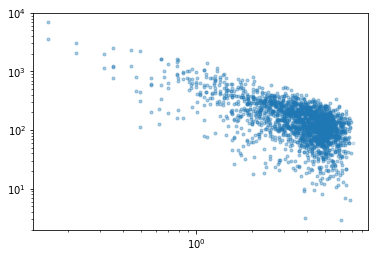

In [42]:
kx = np.fft.fftfreq(64, d=0.1)
ky = np.fft.fftfreq(64, d=0.1)
kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)

plot(kk.ravel(), abs(np.fft.fft2(grfe)).ravel(), '.', alpha=0.2)
yscale('log')
xscale('log')

In [46]:
from sklearn.utils import shuffle

In [76]:
# Train the darn thing
batch_size = 32
epochs = 1000

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
            
    # Generate some true images
    imgs = np.zeros((batch_size, img_rows, img_cols))
    for i in range(batch_size):
        imgs[i] = grf_2d(1.0, alpha=-2.0)
    imgs =imgs.reshape((batch_size, img_rows, img_cols, 1))

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (to have the discriminator label samples as valid)
    discriminator.trainable = False
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    #if epoch % sample_interval == 0:
    #    self.sample_images(epoch)


0 [D loss: 0.712320, acc.: 50.00%] [G loss: 0.839478]
1 [D loss: 0.716504, acc.: 50.00%] [G loss: 0.838611]
2 [D loss: 0.719919, acc.: 50.00%] [G loss: 0.838777]
3 [D loss: 0.717599, acc.: 50.00%] [G loss: 0.833510]
4 [D loss: 0.720352, acc.: 50.00%] [G loss: 0.834288]
5 [D loss: 0.717254, acc.: 50.00%] [G loss: 0.839686]
6 [D loss: 0.713833, acc.: 50.00%] [G loss: 0.840525]
7 [D loss: 0.712296, acc.: 50.00%] [G loss: 0.846019]
8 [D loss: 0.709266, acc.: 50.00%] [G loss: 0.841528]
9 [D loss: 0.713351, acc.: 50.00%] [G loss: 0.841860]
10 [D loss: 0.711138, acc.: 50.00%] [G loss: 0.846202]
11 [D loss: 0.711226, acc.: 50.00%] [G loss: 0.848123]
12 [D loss: 0.710587, acc.: 50.00%] [G loss: 0.849694]
13 [D loss: 0.710811, acc.: 50.00%] [G loss: 0.851243]
14 [D loss: 0.708665, acc.: 50.00%] [G loss: 0.853492]
15 [D loss: 0.709431, acc.: 50.00%] [G loss: 0.855076]
16 [D loss: 0.707045, acc.: 50.00%] [G loss: 0.859821]
17 [D loss: 0.705882, acc.: 50.00%] [G loss: 0.860649]
18 [D loss: 0.704090

150 [D loss: 0.538205, acc.: 89.06%] [G loss: 1.080077]
151 [D loss: 0.547544, acc.: 84.38%] [G loss: 1.062322]
152 [D loss: 0.555958, acc.: 82.81%] [G loss: 1.075511]
153 [D loss: 0.547715, acc.: 78.12%] [G loss: 1.030094]
154 [D loss: 0.543484, acc.: 81.25%] [G loss: 1.103002]
155 [D loss: 0.533879, acc.: 85.94%] [G loss: 1.104216]
156 [D loss: 0.536476, acc.: 84.38%] [G loss: 1.083453]
157 [D loss: 0.539363, acc.: 84.38%] [G loss: 1.105840]
158 [D loss: 0.521695, acc.: 85.94%] [G loss: 1.096212]
159 [D loss: 0.531684, acc.: 85.94%] [G loss: 1.097392]
160 [D loss: 0.522319, acc.: 89.06%] [G loss: 1.082623]
161 [D loss: 0.530965, acc.: 84.38%] [G loss: 1.095212]
162 [D loss: 0.548426, acc.: 82.81%] [G loss: 1.118486]
163 [D loss: 0.524500, acc.: 84.38%] [G loss: 1.088098]
164 [D loss: 0.528993, acc.: 84.38%] [G loss: 1.133167]
165 [D loss: 0.510415, acc.: 85.94%] [G loss: 1.099617]
166 [D loss: 0.526919, acc.: 85.94%] [G loss: 1.098171]
167 [D loss: 0.519369, acc.: 85.94%] [G loss: 1.

296 [D loss: 0.332245, acc.: 98.44%] [G loss: 1.406744]
297 [D loss: 0.332274, acc.: 96.88%] [G loss: 1.383331]
298 [D loss: 0.327886, acc.: 100.00%] [G loss: 1.401032]
299 [D loss: 0.312513, acc.: 100.00%] [G loss: 1.356863]
300 [D loss: 0.343661, acc.: 100.00%] [G loss: 1.442144]
301 [D loss: 0.336221, acc.: 98.44%] [G loss: 1.418436]
302 [D loss: 0.329745, acc.: 98.44%] [G loss: 1.372619]
303 [D loss: 0.323553, acc.: 100.00%] [G loss: 1.431607]
304 [D loss: 0.325196, acc.: 100.00%] [G loss: 1.427466]
305 [D loss: 0.313876, acc.: 98.44%] [G loss: 1.424736]
306 [D loss: 0.301577, acc.: 100.00%] [G loss: 1.427947]
307 [D loss: 0.314860, acc.: 100.00%] [G loss: 1.401195]
308 [D loss: 0.310239, acc.: 100.00%] [G loss: 1.401670]
309 [D loss: 0.317531, acc.: 100.00%] [G loss: 1.441594]
310 [D loss: 0.301340, acc.: 98.44%] [G loss: 1.416257]
311 [D loss: 0.323653, acc.: 100.00%] [G loss: 1.395576]
312 [D loss: 0.306039, acc.: 100.00%] [G loss: 1.408870]
313 [D loss: 0.318263, acc.: 98.44%] 

442 [D loss: 0.238572, acc.: 100.00%] [G loss: 1.669432]
443 [D loss: 0.235933, acc.: 100.00%] [G loss: 1.640665]
444 [D loss: 0.223380, acc.: 100.00%] [G loss: 1.677243]
445 [D loss: 0.228304, acc.: 100.00%] [G loss: 1.673677]
446 [D loss: 0.224245, acc.: 100.00%] [G loss: 1.688083]
447 [D loss: 0.225312, acc.: 100.00%] [G loss: 1.700754]
448 [D loss: 0.219684, acc.: 100.00%] [G loss: 1.728777]
449 [D loss: 0.206313, acc.: 100.00%] [G loss: 1.710760]
450 [D loss: 0.220859, acc.: 98.44%] [G loss: 1.654894]
451 [D loss: 0.220799, acc.: 100.00%] [G loss: 1.680372]
452 [D loss: 0.213736, acc.: 100.00%] [G loss: 1.732551]
453 [D loss: 0.219635, acc.: 100.00%] [G loss: 1.706493]
454 [D loss: 0.218227, acc.: 100.00%] [G loss: 1.722857]
455 [D loss: 0.225999, acc.: 100.00%] [G loss: 1.666876]
456 [D loss: 0.231245, acc.: 100.00%] [G loss: 1.649857]
457 [D loss: 0.215242, acc.: 100.00%] [G loss: 1.716781]
458 [D loss: 0.216845, acc.: 100.00%] [G loss: 1.762435]
459 [D loss: 0.217196, acc.: 100

KeyboardInterrupt: 